# Classifying Galaxy Mergers with Aggregated Attention

- Improve the CNN model using attention for merger-classification
- Edit some codes to resolve `tensorflow` version issues, currently compatible with `2.6.x`. They changed too many for each update.

## Setup and Imports

This example requires TensorFlow Addons, which can be installed using
the following command:

```shell
pip install -U tensorflow-addons
```

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [2]:
import matplotlib.pyplot as plt 
from glob import glob
import numpy as np

from matplotlib.colors import ListedColormap
#from keras.utils.training_utils import multi_gpu_model

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import os
import pandas as pd


import pickle
from joblib import dump, load

# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 13})
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
## version check

print(tf.__version__)

2.6.2


In [4]:
# Set seed for reproducibiltiy
SEED = 42
tf.random.set_seed(SEED)

## Hyperparameters

In [5]:
# DATA
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10  # for CIFAR 10

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size. 4x8=32 4x12=48

# ARCHITECTURE
DIMENSIONS = 256
#DIMENSIONS = 64
SE_RATIO = 8
TRUNK_DEPTH = 4

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

In [6]:
myINPUT_SHAPE = (500, 500, 1)
myNUM_CLASSES = 3
myBATCH_SIZE = 64
myBUFFER_SIZE = myBATCH_SIZE * 2
myEPOCHS = 100
myIMLEN = 500

In [7]:
DIMENSIONS //4

64

## Load Merger Data

#### Load the data from disk 

In [8]:
!pwd

/tf/work/merger/notebook


In [9]:
!ls /tf/work/merger/data/

1000data.pkl  500data.pkl  models


In [10]:
import pickle

with open('/tf/work/merger/data/500data.pkl', "rb") as f:
    data = pickle.load(f)

In [11]:
for eachdata in data:
    print('shape: '+str(eachdata.shape))
    print('dtype: '+str(eachdata.dtype))

shape: (252, 500, 500)
dtype: float64
shape: (252,)
dtype: float64
shape: (64, 500, 500)
dtype: float64
shape: (64,)
dtype: float64
shape: (80, 500, 500)
dtype: float64
shape: (80,)
dtype: float64


In [12]:
x_train = data[0].copy()
y_train = data[1].copy().astype(np.uint8)
x_val = data[2].copy()
y_val = data[3].copy().astype(np.uint8)
x_test = data[4].copy()
y_test = data[5].copy().astype(np.uint8)

In [13]:
import random

numtrain = x_train.shape[0]
print(numtrain)

randidx = list(range(numtrain))
random.shuffle(randidx)

252


In [14]:
x_train = x_train[randidx]
y_train = y_train[randidx]

## Explore the Merger Images

In [15]:
fig=plt.figure(figsize=(14, 36))
for i in range(60):
    ax=plt.subplot(12, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title('Label: '+str(y_train[i]))
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

### Masking and Normalizing Images

In [16]:
medvalue = np.nanmedian(x_train)
minvalue = np.nanmin(x_train)
maxvalue = np.nanmax(x_train)

print([medvalue,minvalue,maxvalue])

[32.02873972939746, 16.373567689693267, 51.882674692480236]


#### Filling `nan` and `inf` pixels 

In [17]:
#x_test[np.isnan(x_test)]=maxvalue
#x_val[np.isnan(x_val)]=maxvalue
#x_train[np.isnan(x_train)]=maxvalue

x_test[np.isnan(x_test)]=medvalue
x_val[np.isnan(x_val)]=medvalue
x_train[np.isnan(x_train)]=medvalue

#### Optional: Median Mask 

In [18]:
#x_test[x_test > medvalue]= medvalue
#x_val[x_val > medvalue]= medvalue
#x_train[x_train > medvalue]= medvalue

#### Masking out SB < 26 mag as SB = 26

In [19]:
#x_test[x_test<26.0]=26.0
#x_val[x_val<26.0]=26.0
#x_train[x_train<26.0]=26.0

x_test[x_test<26.0]=maxvalue
x_val[x_val<26.0]=maxvalue
x_train[x_train<26.0]=maxvalue

#x_test[x_test<26.0]=medvalue
#x_val[x_val<26.0]=medvalue
#x_train[x_train<26.0]=medvalue

#### Reshape and Normalization

In [20]:
for eachdata in [x_train, y_train,x_val, y_val,x_test, y_test]:
    print('shape: '+str(eachdata.shape))
    print('dtype: '+str(eachdata.dtype))

shape: (252, 500, 500)
dtype: float64
shape: (252,)
dtype: uint8
shape: (64, 500, 500)
dtype: float64
shape: (64,)
dtype: uint8
shape: (80, 500, 500)
dtype: float64
shape: (80,)
dtype: uint8


In [21]:
x_train = x_train.reshape((x_train.shape[0],myIMLEN,myIMLEN,1)).astype('float32')
x_test = x_test.reshape((x_test.shape[0],myIMLEN,myIMLEN,1)).astype('float32')
x_val = x_val.reshape((x_val.shape[0],myIMLEN,myIMLEN,1)).astype('float32')

y_train = y_train.reshape((y_train.shape[0],1))
y_val = y_val.reshape((y_val.shape[0],1))
y_test = y_test.reshape((y_test.shape[0],1))

In [22]:
maxval = np.max([np.max(x_train),np.max(x_val),np.max(x_test)])
minval = np.min([np.min(x_train),np.min(x_val),np.min(x_test)])

In [23]:
x_train = np.abs(1.0 - (x_train - minval) / (maxval - minval))
x_test = np.abs(1.0 - (x_test - minval) / (maxval - minval))
x_val = np.abs(1.0 - (x_val - minval) / (maxval - minval))

In [24]:
for eachdata in [x_train, y_train,x_val, y_val,x_test, y_test]:
    print('shape: '+str(eachdata.shape))
    print('dtype: '+str(eachdata.dtype))

shape: (252, 500, 500, 1)
dtype: float32
shape: (252, 1)
dtype: uint8
shape: (64, 500, 500, 1)
dtype: float32
shape: (64, 1)
dtype: uint8
shape: (80, 500, 500, 1)
dtype: float32
shape: (80, 1)
dtype: uint8


In [25]:
np.nanmax(x_test), np.nanmin(x_test), np.nanmax(x_train), np.nanmin(x_train), np.nanmax(x_val), np.nanmin(x_val)

(0.9999999, 0.0, 0.99999994, 0.0, 1.0, 0.0)

#### Show images after normalization

In [26]:
fig=plt.figure(figsize=(14, 36))
for i in range(60):
    ax=plt.subplot(12, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title('Label: '+str(y_train[i]))
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

#### Prefetch Datasets 

- The `PrefetchDataset` in TensorFlow is a dataset that asynchronously prefetches elements from another dataset. This can be used to improve the performance of machine learning models by reducing the amount of time spent waiting for data.

- The `PrefetchDataset` takes two arguments: the input dataset and the number of elements to prefetch. The number of elements to prefetch should be a positive integer.

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(myBUFFER_SIZE).batch(myBATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(myBATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(myBATCH_SIZE).prefetch(AUTO)

## [1] Basic Layers 

### Convolutional stem

The stem of the model is a lightweight preprocessing module that
maps images pixels to a set of vectors (patches).

- Recall: <br>
`
DIMENSIONS = 128
SE_RATIO = 8
TRUNK_DEPTH = 2
`

#Original Function

def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem

In [28]:
# for default, dimensions = 256
def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }
    
    config31 = {
        "kernel_size": (3, 3),
        "strides": (1, 1),
        "activation": tf.nn.gelu,
        "padding": "same",
    }

    
    config4 = {
        "kernel_size": (4, 4),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }
    
    config5 = {
        "kernel_size": (5, 5),
        "strides": (3, 3),
        "activation": tf.nn.gelu,
        "padding": "same",
    }
    
    config51 = {
        "kernel_size": (5, 5),
        "strides": (1, 1),
        "activation": tf.nn.gelu,
        "padding": "same",
    }
    
    config52 = {
        "kernel_size": (5, 5),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }
    
    config7 = {
        "kernel_size": (7, 7),
        "strides": (4, 4),
        "activation": tf.nn.gelu,
        "padding": "same",
    }
    
    config25 = {
        "kernel_size": (25, 25),
        "strides": (13, 13),
        "activation": tf.nn.gelu,
        "padding": "same",
    }
    
    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 8, **config52),
            layers.Conv2D(filters=dimensions // 4, **config52),
            layers.Conv2D(filters=dimensions // 2, **config52),
            layers.Conv2D(filters=dimensions, **config52),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem


- FYI: The **dictionary** `config` has four `keys`: `kernel_size, strides, activation,` and `padding`.

## [2] Core Steps

### Convolutional trunk

The trunk of the model is the most compute-intesive part. It consists
of `N` stacked residual convolutional blocks.

In [29]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

The class `SqueezeExcite` is a popular attention mechanism that can be used to improve the performance of convolutional neural networks (CNNs).

The SqueezeExcite layer takes two arguments: the `ratio` and the `**kwargs`. The `ratio` argument is a float that specifies the ratio with which the feature map needs to be reduced in the reduction phase. The `**kwargs` argument is a dictionary of keyword arguments that can be used to customize the layer.

The SqueezeExcite layer has four steps:

- The **squeeze** layer performs global average pooling on the input feature maps. This reduces the feature maps to a single vector.
- The **reduction** layer applies a dense layer with a ReLU activation function to the output of the squeeze layer. This reduces the size of the vector.
- The **excite** layer applies a dense layer with a sigmoid activation function to the output of the reduction layer. This produces a vector of weights.
- The **multiply** layer multiplies the output of the squeeze layer by the output of the excite layer. This produces the output of the SqueezeExcite layer.

In [30]:
class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692

    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio

    Inputs:
        Convolutional features extracted from the conv stem.

    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {"ratio": self.ratio, "dimensions": self.dimensions, "depth": self.depth,}
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": tf.nn.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        return x

The **Trunk layer** has five steps:

- The `LayerNormalization` layer normalizes the input feature maps. This helps to improve the stability of the training process.
- The `Conv2D` layer applies a convolutional layer with the specified number of filters and activation function to the normalized feature maps.
- The `Conv2D` layer applies another convolutional layer with the specified number of filters and activation function to the output of the first convolutional layer.
- The `SqueezeExcite` layer applies the SqueezeExcite attention mechanism to the output of the second convolutional layer.
- The `Conv2D` layer applies a final convolutional layer with the specified number of filters to the output of the SqueezeExcite layer.

### Attention Pooling

The output of the convolutional trunk is attended with a trainable
_query_ class token. The resulting attention map is the weight of
every patch of the image for a classification decision.

In [31]:
class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the
    trunk with the CLS token.

    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.

    Inputs:
        Flattened patches from the trunk.

    Outputs:
        The modifies CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = tf.Variable(tf.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1, key_dim=self.dimensions, dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
            ]
        )
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Expand the class token batch number of times.
        class_token = tf.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = tf.concat([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        # Build the logits
        logits = self.dense(class_token)
        return logits, tf.squeeze(viz_weights)[..., 1:]


The `AttentionPooling` layer is a class in Keras that can be used to apply attention to the patches extracted from the trunk with the `CLS` token.

The `AttentionPooling` layer takes two arguments: the `dimensions` and the `num_classes`. The dimensions argument is an integer that specifies the number of features in the input data. The num_classes argument is an integer that specifies the number of classes in the dataset.

The `AttentionPooling` layer has six steps:

- The `cls` variable is initialized to a tensor of zeros with the shape `(1, 1, dimensions)`. This tensor will be used as the `CLS` token.
- The `attention` layer applies `multi-head attention` to the input data. This layer takes three inputs: the query, the key, and the value. The query is the CLS token. The key and the value are the flattened patches extracted from the trunk.
- The `layer_norm1` layer normalizes the output of the attention layer. This helps to improve the stability of the training process.
- The `viz_weights` tensor is the attention weights. It can be used to visualize how the attention layer is attending to the different patches.
- The `class_token` tensor is the output of the attention layer. It is a weighted sum of the flattened patches extracted from the trunk.
- The `class_token` tensor is passed through a series of dense layers to produce the logits. The logits are the predictions for the classes.

#### FYI: Multi-head attention and CLS token 

**Multi-head attention** is a technique that allows the model to attend to different parts of the input sequence in different ways. This is done by dividing the input sequence into multiple heads, and then attending to each head separately. The output of the attention layer is then a weighted sum of the outputs of the different heads.

**CLS token (Classification token)** is a special token that is added to the beginning of the input sequence and is used to represent the overall class of the input. The CLS token is used in attention-based models because it allows the model to learn the relationship between the different parts of the input sequence and the overall class of the input.

**How do they work together?**

Multi-head attention and CLS token can be used together to improve the performance of attention-based deep learning models. The CLS token is used to represent the overall class of the input sequence, and the multi-head attention layer is used to attend to different parts of the input sequence in different ways. This allows the model to learn the relationship between the different parts of the input sequence and the overall class of the input.

For example, in a text classification task, the **CLS token** could be used to represent the **overall sentiment** of the text. The **multi-head attention** layer could then be used to attend to different parts of the text, such as the **individual words, the phrases, and the sentences**. This would allow the model to learn how the different parts of the text contribute to the overall sentiment of the text.





## [3] Wrap up: Patch Convnet 

The patch-convnet is shown in the figure below.

| ![image model](https://i.imgur.com/NHiQeac.png) |
| :--: |
| [Source](https://arxiv.org/abs/2112.13692) |

All the modules in the architecture are built in the earlier seciton.
In this section, we stack all of the different modules together.

In [32]:
class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        #preprocessing_model,
        #train_augmentation_model,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        #self.train_augmentation_model = train_augmentation_model
        #self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                #"train_augmentation_model": self.train_augmentation_model,
                #"preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        #if test:
        #    augmented_images = self.preprocessing_model(images)
        #else:
        #    augmented_images = self.train_augmentation_model(images)
        augmented_images = images # pre-augmented images; no need these steps
        
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        #augmented_images = self.preprocessing_model(images)
        augmented_images = images
        
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights


## Callbacks

This callback will plot the image and the attention map overlayed on
the image.

In [33]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_labels = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            # Augmentation
            #test_augmented_images = self.model.preprocessing_model(test_images)
            test_augmented_images = test_images
            
            # Pass through the stem.
            test_x = self.model.stem(test_augmented_images)
            # Pass through the trunk.
            test_x = self.model.trunk(test_x)
            # Pass through the attention pooling block.
            _, test_viz_weights = self.model.attention_pooling(test_x)
            # Reshape the vizualization weights
            num_patches = tf.shape(test_viz_weights)[-1]
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            # Take a random image and its attention weights.
            index = np.random.randint(low=0, high=tf.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            # Plot the images and the overlayed attention map.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(
                selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent()
            )
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()


## Learning rate schedule

In [34]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

## Training

We build the model, compile it, and train it.

Epoch 1/100
4/4 [==============================] - 9s 747ms/step - loss: 2.2451 - accuracy: 0.3492 - top-5-accuracy: 1.0000 - val_loss: 1.2085 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 2/100
4/4 [==============================] - 1s 290ms/step - loss: 2.4019 - accuracy: 0.5952 - top-5-accuracy: 1.0000 - val_loss: 1.8918 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 1s 288ms/step - loss: 1.6716 - accuracy: 0.4841 - top-5-accuracy: 1.0000 - val_loss: 1.4535 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 1s 288ms/step - loss: 1.1424 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 1.0988 - val_accuracy: 0.2656 - val_top-5-accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 1s 290ms/step - loss: 0.9265 - accuracy: 0.6349 - top-5-accuracy: 1.0000 - val_loss: 0.8689 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 6/100
4/4 [==============================] - 1s 287ms/step - loss: 0.8310 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.8103 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 1s 289ms/step - loss: 0.8282 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 8/100
4/4 [==============================] - 1s 288ms/step - loss: 0.8134 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.8465 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 9/100
4/4 [==============================] - 1s 289ms/step - loss: 0.8244 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.8056 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 10/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7961 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.8103 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


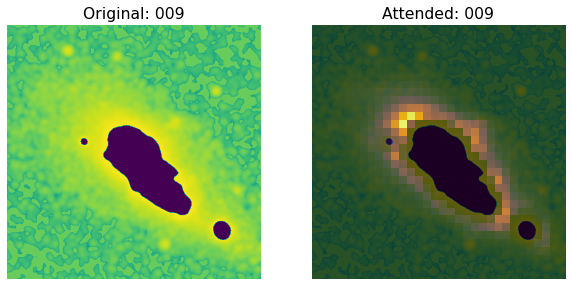

Epoch 11/100
4/4 [==============================] - 1s 290ms/step - loss: 0.8235 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.8041 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 12/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7910 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7985 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 13/100
4/4 [==============================] - 1s 291ms/step - loss: 0.8072 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.8061 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 14/100
4/4 [==============================] - 1s 289ms/step - loss: 0.7960 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7983 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 15/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7941 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7960 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 16/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7947 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7946 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 17/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7934 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7939 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 18/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7885 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7948 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 19/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7874 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7936 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 20/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7884 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7945 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 21/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7863 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 22/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7851 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 23/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 24/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 25/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7843 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 26/100
4/4 [==============================] - 1s 288ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 27/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7843 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 28/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7843 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 29/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 30/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7843 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


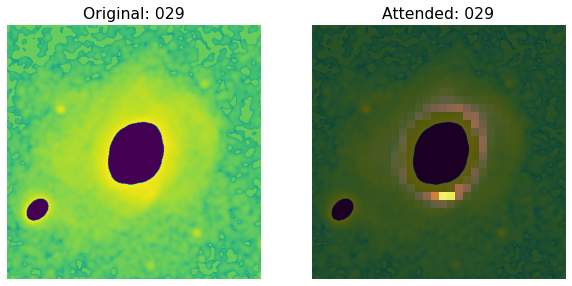

Epoch 31/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 32/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 33/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 34/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 35/100
4/4 [==============================] - 1s 290ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 36/100
4/4 [==============================] - 1s 289ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 37/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7844 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 38/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 39/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 40/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 41/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 42/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 43/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 44/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 45/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 46/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 47/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7845 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 48/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 49/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 50/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 51/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 52/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 53/100
4/4 [==============================] - 1s 291ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 54/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7846 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7921 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 55/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7847 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


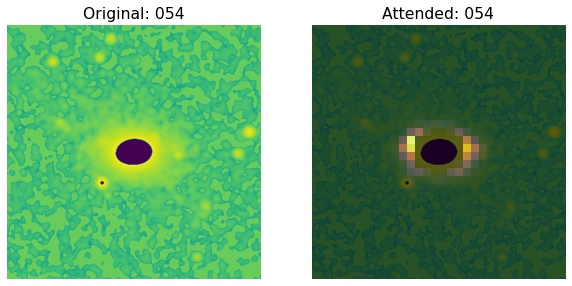

Epoch 56/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7847 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 57/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7847 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 58/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7847 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 59/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 60/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


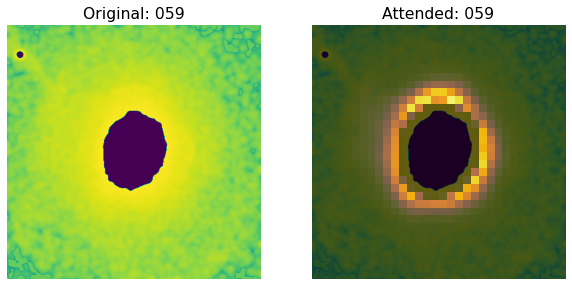

Epoch 61/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 62/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 63/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 64/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 65/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


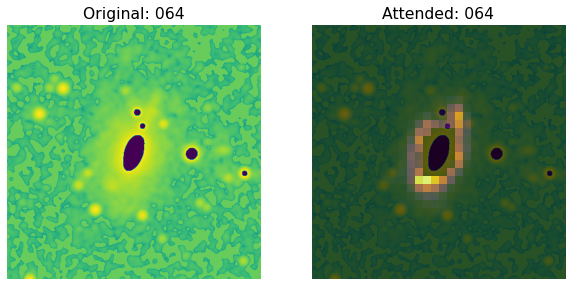

Epoch 66/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7848 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 67/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7849 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 68/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7849 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 69/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7849 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 70/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7849 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


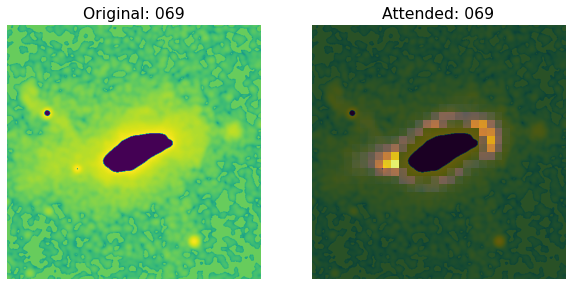

Epoch 71/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7849 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 72/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7849 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 73/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7850 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 74/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7850 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 75/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7850 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 76/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7850 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 77/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7850 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 78/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7851 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 79/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7851 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 80/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7851 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 81/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7852 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 82/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7852 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 83/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7852 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 84/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7852 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 85/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7852 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


Epoch 86/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7852 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7926 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 87/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7853 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7926 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 88/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7853 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7926 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 89/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7853 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7926 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 90/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7853 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7926 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


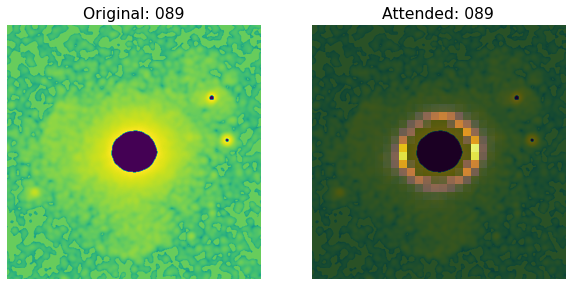

Epoch 91/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7854 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7927 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 92/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7854 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7927 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 93/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7854 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7927 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 94/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7854 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7927 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 95/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7855 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7927 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


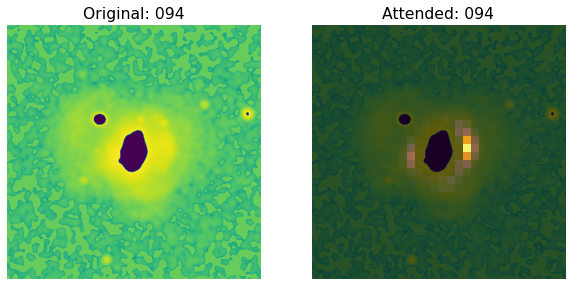

Epoch 96/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7855 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7927 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 97/100
4/4 [==============================] - 1s 294ms/step - loss: 0.7855 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7928 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 98/100
4/4 [==============================] - 1s 293ms/step - loss: 0.7855 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7928 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 99/100
4/4 [==============================] - 1s 292ms/step - loss: 0.7856 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7928 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000
Epoch 100/100
4/4 [==============================] - 1s 295ms/step - loss: 0.7856 - accuracy: 0.6746 - top-5-accuracy: 1.0000 - val_loss: 0.7928 - val_accuracy: 0.6719 - val_top-5-accuracy: 1.0000


2/2 [==============================] - 0s 146ms/step - loss: 0.7899 - accuracy: 0.6750 - top-5-accuracy: 1.0000
Loss: 0.79
Top 1 test accuracy: 67.50%
Top 5 test accuracy: 100.00%
CPU times: user 1min 20s, sys: 49.6 s, total: 2min 9s
Wall time: 2min 20s


In [35]:
%%time

#train_augmentation_model = get_train_augmentation_model()
#preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=myNUM_CLASSES)

patch_conv_net = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    #train_augmentation_model=train_augmentation_model,
    #preprocessing_model=preprocessing_model,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]
# Get the optimizer.
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
# Compile and pretrain the model.
patch_conv_net.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = patch_conv_net.fit(
    train_ds, epochs=myEPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Evaluate the model with the test dataset.
loss, acc_top1, acc_top5 = patch_conv_net.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1*100:0.2f}%")
print(f"Top 5 test accuracy: {acc_top5*100:0.2f}%")

## Confusion Matrix 

In [36]:
y_pred_raw=patch_conv_net.predict(test_ds)

In [37]:
for index, item in enumerate(y_pred_raw):
    print(index, item.dtype, item.shape)

0 float32 (80, 3)
1 float32 (80, 1024)


- Outputs : `logits`,`viz_weights`
- `logits` should be converted to probabilities using `tf.sigmoid()` 

In [38]:
y_pred = np.array(tf.sigmoid(y_pred_raw[0]))
print([y_pred.shape, y_pred.dtype])

[(80, 3), dtype('float32')]


In [39]:
y_pred.shape, y_pred.dtype

((80, 3), dtype('float32'))

In [40]:
confM=confusion_matrix(y_test.flatten(),np.argmax(y_pred,axis=1))

In [41]:
class_totals = np.sum(confM, axis=1)
cm_norm = confM / class_totals[:, np.newaxis]

In [42]:
labels=['MergerX','MergerO','MergerΔ']
#print(data)
# Drawing confusion matrix with seaborn
plt.figure(figsize=(12,5))

ax=plt.subplot(1, 2, 1)
#sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
sns.heatmap(confM,annot=True,cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
plt.ylabel('actual value')

ax=plt.subplot(1, 2, 2)
sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
#sns.heatmap(confM,annot=True,cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
#plt.ylabel('actual value')


plt.tight_layout()
#plt.title(model_name)
plt.show() 

In [43]:
report=classification_report(y_test.flatten(),np.argmax(y_pred,axis=1),output_dict=True)

df=pd.DataFrame(report).transpose()
#df.to_hdf('/tf/Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.h5',key='Galaxy',mode='w')   
df

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score  support
0              0.675000  1.000000  0.805970   54.000
1              0.000000  0.000000  0.000000   21.000
2              0.000000  0.000000  0.000000    5.000
accuracy       0.675000  0.675000  0.675000    0.675
macro avg      0.225000  0.333333  0.268657   80.000
weighted avg   0.455625  0.675000  0.544030   80.000

In [44]:
# plotting the metrics
fig = plt.figure(figsize=(10,2.5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.show()

## Inference

Here, we use the trained model to plot the attention map.

In [45]:
def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    image = tf.image.resize(image, (32, 32))
    image = image[tf.newaxis, ...]
    test_augmented_images = patch_conv_net.preprocessing_model(image)
    # Pass through the stem.
    test_x = patch_conv_net.stem(test_augmented_images)
    # Pass through the trunk.
    test_x = patch_conv_net.trunk(test_x)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_conv_net.attention_pooling(test_x)
    test_viz_weights = test_viz_weights[tf.newaxis, ...]
    # Reshape the vizualization weights.
    num_patches = tf.shape(test_viz_weights)[-1]
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    selected_image = test_augmented_images[0]
    selected_weight = test_viz_weights[0]
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


#url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
#image_name = keras.utils.get_file(fname="image.jpg", origin=url)
#image = tf.io.read_file(image_name)
#image = tf.io.decode_image(image)
#plot_attention(image)

# Original Notebook Information

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2022/01/22<br>
**Last modified:** 2022/01/22<br>
**Description:** Building a patch-convnet architecture and visualizing its attention maps.

Vision transformers ([Dosovitskiy et. al](https://arxiv.org/abs/2010.11929))
have emerged as a powerful alternative to Convolutional Neural Networks.
ViTs process the images in a patch-based manner. The image information
is then aggregated into a `CLASS` token. This token correlates to the
most important patches of the image for a particular classification decision.

The interaction between the `CLASS` token and the patches can be visualized
to help explain a classification decision. In the academic paper
[Augmenting convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692)
by Touvron et. al, the authors propose to set up an equivalent visualization for
convnets. They propose to substitute the global average pooling layer
of a convnet with a Transformer layer. The self-attention layer of the
Transformer would produces attention maps that correspond to the
most attended patches of the image for the classification decision.

In this example, we minimally implement the ideas of
[Augmenting Convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692).
The main goal of this example is to cover the following ideas, with
minor modifications (to adjust the implementation with CIFAR10):

- The simple design for the attention-based pooling layer, such that
    it explicitly provides the weights (importance) of the different
    patches.
- The novel architecture of convnet called the **PatchConvNet** which
    deviates from the age old pyramidal architecture.
    
    
### Conclusions

The attention map corresponding to the trainable `CLASS`
token and the patches of the image helps explain the classificaiton
decision. One should also note that the attention maps gradually get
better. In the initial training regime, the attention is scattered all
around while at a later stage, it focuses more on the objects of the
image.

The non-pyramidal convnet achieves an accuracy of ~84-85% top-1 test
accuracy.

I would like to thank [JarvisLabs.ai](https://jarvislabs.ai/) for
providing GPU credits for this project.

You can try the model on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/patch-conv-net).